<a href="https://colab.research.google.com/github/jgssung/IoT_Lab2/blob/main/AGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Device: cpu
>>> Fashion-MNIST 로드 및 Non-IID 분할...

[Simulation] FedAvg vs FedProx vs AGS(Adaptive)
Round|Avg Acc |Prox Acc|AGS Acc |AGS k 
  1  | 10.69  | 15.56  | 20.90  | 0.50 
  2  | 17.04  | 23.99  | 23.74  | 0.50 
  3  | 29.94  | 31.18  | 27.50  | 0.01 
  4  | 40.31  | 33.87  | 28.61  | 0.01 
  5  | 42.74  | 43.54  | 29.00  | 0.01 
  6  | 51.05  | 43.06  | 30.12  | 0.01 
  7  | 43.80  | 37.58  | 20.40  | 1.00 
  8  | 42.76  | 40.29  | 35.69  | 0.98 
  9  | 43.93  | 51.40  | 45.33  | 0.01 
 10  | 56.17  | 53.36  | 46.21  | 0.01 
 11  | 53.53  | 39.97  | 43.32  | 0.01 
 12  | 49.81  | 42.81  | 37.56  | 1.00 
 13  | 54.56  | 51.49  | 43.66  | 1.00 
 14  | 53.80  | 54.97  | 49.20  | 0.01 
 15  | 63.17  | 55.05  | 48.28  | 0.01 
 16  | 59.81  | 56.08  | 44.32  | 0.01 
 17  | 65.72  | 62.86  | 46.84  | 0.01 
 18  | 67.34  | 64.40  | 49.39  | 1.00 
 19  | 62.47  | 67.23  | 58.80  | 1.00 
 20  | 54.66  | 64.03  | 63.70  | 1.00 
 21  | 61.23  | 68.42  | 62.71  | 0.01 
 22  | 56.82  | 

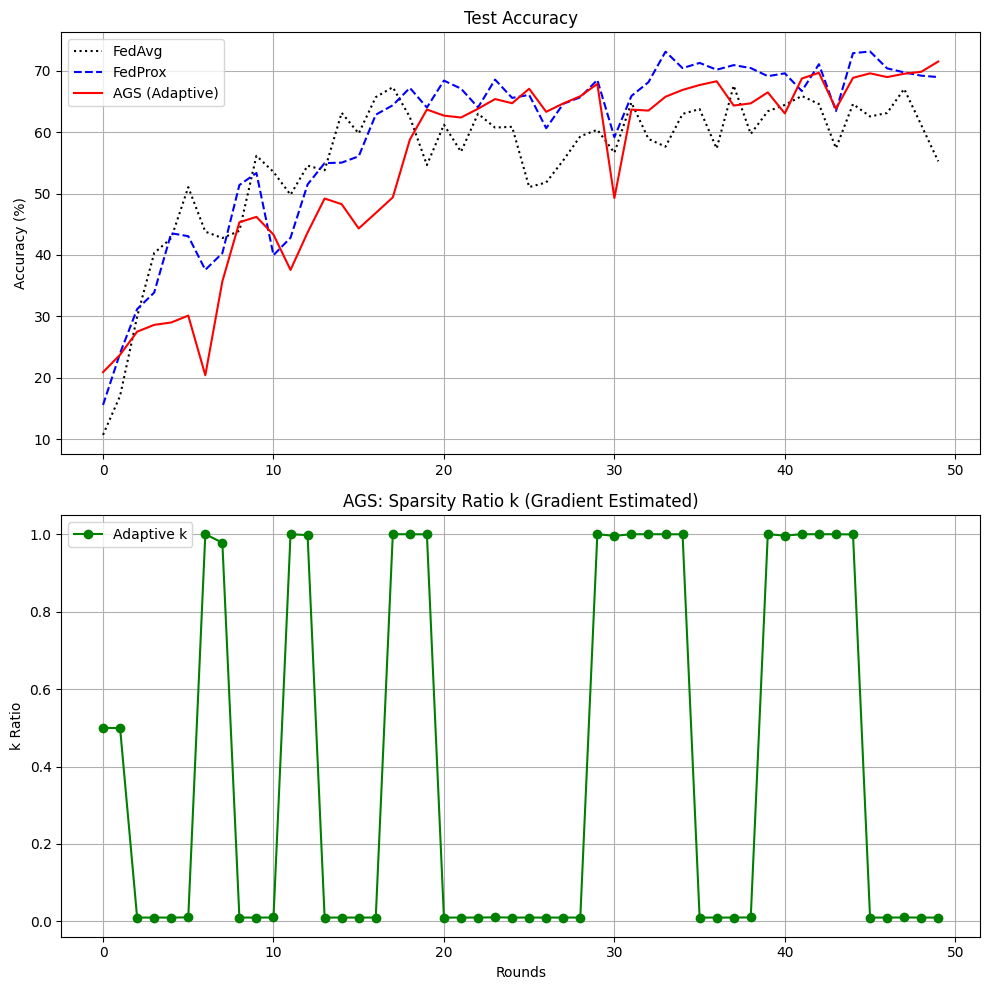

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import copy
import random
import matplotlib.pyplot as plt

# ==============================================================================
# [설정] FedAvg vs FedProx vs AGS(Adaptive k + FAB-top-k + Gradient Est.)
# ==============================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

NUM_CLIENTS = 20
NUM_SELECTED = 10
NUM_ROUNDS = 50
BATCH_SIZE = 10
LR = 0.1
MU = 1.0

# [요청하신 기능 1, 3 관련: AGS 하이퍼파라미터]
INITIAL_K = 0.5      # 초기 k 비율
ETA_K = 0.05         # k값 학습률 (Step size)
LAMBDA_COST = 0.1    # 비용 함수 내 통신 비용 가중치

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)

# ==============================================================================
# 1. Dataset & Model
# ==============================================================================
def get_fashion_mnist_noniid():
    print(">>> Fashion-MNIST 로드 및 Non-IID 분할...")
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_ds = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    test_ds = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

    data_by_class = {i: [] for i in range(10)}
    for idx, target in enumerate(train_ds.targets):
        data_by_class[target.item()].append(idx)

    shards = []
    for cls in range(10):
        indices = data_by_class[cls]
        shard_len = len(indices) // 4
        for i in range(4):
            shards.append(indices[i*shard_len : (i+1)*shard_len])

    random_state = np.random.RandomState(42)
    random_state.shuffle(shards)

    client_indices = []
    for i in range(NUM_CLIENTS):
        client_indices.append(shards[2*i] + shards[2*i+1])

    return train_ds, test_ds, client_indices

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ==============================================================================
# [요청 기능 3] 미분값의 부호를 추정하여 k값을 조절하는 Controller
# ==============================================================================
class AGSController:
    def __init__(self):
        self.current_k = INITIAL_K
        self.prev_k = INITIAL_K
        self.prev_cost = 0.0
        self.eta = ETA_K
        self.min_k = 0.01
        self.max_k = 1.0

    def calculate_cost(self, val_loss, k_ratio):
        # Cost = Validation Loss + (lambda * Communication Cost)
        # 통신 비용은 k 비율에 비례한다고 가정
        return val_loss + (LAMBDA_COST * k_ratio)

    def update_k(self, current_loss):
        """
        [논문 핵심] 미분값(Gradient) 추정 및 k 업데이트
        g_t ≈ (Cost_t - Cost_{t-1}) / (k_t - k_{t-1})
        """
        current_cost = self.calculate_cost(current_loss, self.current_k)

        # 1. 변화량 계산
        delta_k = self.current_k - self.prev_k
        delta_cost = current_cost - self.prev_cost

        # 2. 미분값(기울기) 추정
        if abs(delta_k) < 1e-6:
            # k 변화가 거의 없으면 랜덤 노이즈로 탐색 (Division by zero 방지)
            estimated_grad = np.random.randn() * 0.01
        else:
            estimated_grad = delta_cost / delta_k

        # 3. k 업데이트 (Gradient Descent: k_next = k - eta * grad)
        next_k = self.current_k - (self.eta * estimated_grad)

        # 범위 제한 (0.01 ~ 1.0)
        next_k = np.clip(next_k, self.min_k, self.max_k)

        # 상태 저장
        self.prev_k = self.current_k
        self.prev_cost = current_cost
        self.current_k = next_k

        return self.current_k

# ==============================================================================
# 2. Local Training (AGS: Adaptive k 적용)
# ==============================================================================
class LocalUpdate:
    def __init__(self, dataset, indices, device, client_id):
        self.loader = DataLoader(Subset(dataset, indices), batch_size=BATCH_SIZE, shuffle=True)
        self.device = device
        self.client_id = client_id
        self.criterion = nn.CrossEntropyLoss()
        self.residual = {} # Error Feedback용

    def train(self, global_model, mu, is_prox, use_ags=False, ags_ratio=0.5):
        model = copy.deepcopy(global_model).to(self.device)
        model.train()
        optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.5)
        global_params = [p.clone().detach() for p in global_model.parameters()]

        # 이종성 시뮬레이션 (Epoch 다르게 설정)
        epochs = 1 if self.client_id % 3 == 0 else 5

        for _ in range(epochs):
            for data, target in self.loader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = model(data)
                loss = self.criterion(output, target)

                if is_prox and mu > 0:
                    prox_term = 0.0
                    for w, w_t in zip(model.parameters(), global_params):
                        prox_term += (w - w_t.to(self.device)).norm(2)**2
                    loss += (mu / 2) * prox_term

                loss.backward()
                optimizer.step()

        final_state = model.state_dict()

        if use_ags:
            # [요청 기능 1] 고정된 k가 아닌, 전달받은 ags_ratio(적응형 k) 사용
            return self.apply_ags(final_state, global_model.state_dict(), ags_ratio)
        else:
            return final_state, len(self.loader.dataset)

    def apply_ags(self, local_state, global_state, ratio):
        """
        Client Side Top-k Sparsification
        """
        sparse_diff = {}
        total_params = sum(p.numel() for p in local_state.values())
        k_target = int(total_params * ratio)

        # 전체 Gradient(변화량) + Residual 통합
        all_deltas = []
        temp_deltas = {}

        for key in local_state.keys():
            delta = local_state[key] - global_state[key].to(self.device)
            if key not in self.residual:
                self.residual[key] = torch.zeros_like(delta)
            delta += self.residual[key]

            temp_deltas[key] = delta
            all_deltas.append(delta.flatten())

        full_vec = torch.cat(all_deltas)

        # Top-k Thresholding
        if k_target > 0:
            topk_vals, _ = torch.topk(torch.abs(full_vec), k_target)
            threshold = topk_vals[-1]
        else:
            threshold = float('inf')

        for key in local_state.keys():
            delta = temp_deltas[key]
            mask = torch.abs(delta) >= threshold
            sparse_val = delta * mask.float()

            self.residual[key] = delta - sparse_val
            sparse_diff[key] = sparse_val

        return sparse_diff, len(self.loader.dataset)

# ==============================================================================
# 3. Server Logic
# ==============================================================================
def average_weights(w_list, counts):
    """FedAvg/FedProx용 단순 평균"""
    w_avg = copy.deepcopy(w_list[0])
    total_count = sum(counts)
    for k in w_avg.keys():
        w_avg[k] = w_avg[k] * counts[0]
        for i in range(1, len(w_list)):
            w_avg[k] += w_list[i][k] * counts[i]
        w_avg[k] = w_avg[k] / total_count
    return w_avg

# [요청 기능 2] FAB-top-k 구현 (Bidirectional)
def fab_top_k_aggregation(diff_list, counts, global_model, ratio):
    """
    서버에서도 Global Top-k를 수행하여 Downlink(서버->클라이언트) 통신도 압축
    """
    total_count = sum(counts)
    aggregated_diff = {}

    # 1. 가중 평균 (Aggregation)
    # 초기화
    first_diff = diff_list[0]
    for k in first_diff.keys():
        aggregated_diff[k] = torch.zeros_like(first_diff[k])

    for i, diff in enumerate(diff_list):
        for k in diff.keys():
            aggregated_diff[k] += diff[k] * counts[i]

    for k in aggregated_diff.keys():
        aggregated_diff[k] /= total_count

    # 2. [핵심] Downlink Sparsification (Global Top-k)
    total_params = sum(p.numel() for p in aggregated_diff.values())
    k_target = int(total_params * ratio)

    all_vals = []
    for k in aggregated_diff.keys():
        all_vals.append(aggregated_diff[k].flatten())
    full_vec = torch.cat(all_vals)

    if k_target > 0:
        topk_vals, _ = torch.topk(torch.abs(full_vec), k_target)
        threshold = topk_vals[-1]
    else:
        threshold = float('inf')

    # 3. Global Model Update 적용
    final_state = copy.deepcopy(global_model.state_dict())
    for k in aggregated_diff.keys():
        mask = torch.abs(aggregated_diff[k]) >= threshold
        sparse_update = aggregated_diff[k] * mask.float()
        final_state[k] += sparse_update.to(DEVICE)

    return final_state

def evaluate(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct = 0; total = 0
    test_loss = 0.0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total, test_loss / len(test_loader)

# ==============================================================================
# 4. Main Experiment
# ==============================================================================
def run_experiment():
    train_ds, test_ds, user_groups = get_fashion_mnist_noniid()
    test_loader = DataLoader(test_ds, batch_size=100, shuffle=False)

    model_avg = SimpleNN().to(DEVICE)
    model_prox = SimpleNN().to(DEVICE)
    model_ags = SimpleNN().to(DEVICE)

    # 동일한 초기화
    init_state = copy.deepcopy(model_avg.state_dict())
    model_prox.load_state_dict(init_state)
    model_ags.load_state_dict(init_state)

    clients_avg = [LocalUpdate(train_ds, user_groups[i], DEVICE, i) for i in range(NUM_CLIENTS)]
    clients_prox = [LocalUpdate(train_ds, user_groups[i], DEVICE, i) for i in range(NUM_CLIENTS)]
    clients_ags = [LocalUpdate(train_ds, user_groups[i], DEVICE, i) for i in range(NUM_CLIENTS)]

    # [AGS Controller 초기화]
    ags_controller = AGSController()

    h_acc_avg, h_loss_avg = [], []
    h_acc_prox, h_loss_prox = [], []
    h_acc_ags, h_loss_ags = [], []
    h_ags_k = []

    print(f"\n[Simulation] FedAvg vs FedProx vs AGS(Adaptive)")
    print(f"{'Round':^5}|{'Avg Acc':^8}|{'Prox Acc':^8}|{'AGS Acc':^8}|{'AGS k':^6}")
    print("="*55)

    for round_idx in range(NUM_ROUNDS):
        idxs_users = np.random.choice(range(NUM_CLIENTS), NUM_SELECTED, replace=False)

        # 1. FedAvg
        w_list, s_list = [], []
        for idx in idxs_users:
            w, s = clients_avg[idx].train(model_avg, 0.0, False, use_ags=False)
            w_list.append(w); s_list.append(s)
        model_avg.load_state_dict(average_weights(w_list, s_list))

        # 2. FedProx
        w_list, s_list = [], []
        for idx in idxs_users:
            w, s = clients_prox[idx].train(model_prox, MU, True, use_ags=False)
            w_list.append(w); s_list.append(s)
        model_prox.load_state_dict(average_weights(w_list, s_list))

        # 3. AGS (Adaptive k + FAB-top-k)
        # 3-1. 현재 라운드의 적응형 k값 가져오기
        current_k = ags_controller.current_k

        g_list, s_list = [], []
        for idx in idxs_users:
            # Client는 적응형 k를 받아서 Top-k Sparsification 수행
            grad, s = clients_ags[idx].train(model_ags, MU, True, use_ags=True, ags_ratio=current_k)
            g_list.append(grad); s_list.append(s)

        # 3-2. FAB-top-k Aggregation (서버도 k만큼만 다시 보냄)
        new_state = fab_top_k_aggregation(g_list, s_list, model_ags, current_k)
        model_ags.load_state_dict(new_state)

        # Evaluation
        acc_avg, loss_avg = evaluate(model_avg, test_loader, DEVICE)
        acc_prox, loss_prox = evaluate(model_prox, test_loader, DEVICE)
        acc_ags, loss_ags = evaluate(model_ags, test_loader, DEVICE)

        # 3-3. [핵심] 미분값을 통한 k 업데이트
        ags_controller.update_k(loss_ags)

        h_acc_avg.append(acc_avg); h_loss_avg.append(loss_avg)
        h_acc_prox.append(acc_prox); h_loss_prox.append(loss_prox)
        h_acc_ags.append(acc_ags); h_loss_ags.append(loss_ags)
        h_ags_k.append(current_k)

        print(f"{round_idx+1:^5}|{acc_avg:^8.2f}|{acc_prox:^8.2f}|{acc_ags:^8.2f}|{current_k:^6.2f}")

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    ax1.plot(h_acc_avg, 'k:', label='FedAvg')
    ax1.plot(h_acc_prox, 'b--', label='FedProx')
    ax1.plot(h_acc_ags, 'r-', label='AGS (Adaptive)')
    ax1.set_title("Test Accuracy")
    ax1.set_ylabel("Accuracy (%)")
    ax1.legend(); ax1.grid()

    ax2.plot(h_ags_k, 'g-o', label='Adaptive k')
    ax2.set_title("AGS: Sparsity Ratio k (Gradient Estimated)")
    ax2.set_xlabel("Rounds")
    ax2.set_ylabel("k Ratio")
    ax2.legend(); ax2.grid()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_experiment()

In [ ]:
# ==============================================================================
# [수정됨] AGS Controller: 안정적인 k값 업데이트를 위한 보정 로직 추가
# ==============================================================================
class AGSController:
    def __init__(self):
        self.current_k = INITIAL_K
        self.prev_k = INITIAL_K
        self.prev_cost = 0.0
        self.eta = ETA_K
        self.min_k = 0.1  # 최소값을 0.01에서 0.1로 올림 (너무 갉아먹지 않게)
        self.max_k = 1.0

        # [추가] Loss가 튀는 것을 막기 위한 이동 평균 변수
        self.moving_avg_loss = None
        self.alpha = 0.6  # 이동 평균 반영 비율 (높을수록 현재 값 비중 큼)

    def calculate_cost(self, val_loss, k_ratio):
        # Cost = Loss + (Lambda * k)
        return val_loss + (LAMBDA_COST * k_ratio)

    def update_k(self, current_raw_loss):
        # 1. Loss Smoothing (이동 평균 적용)
        # 클라이언트 뽑기 운빨로 Loss가 튀는 것을 방지
        if self.moving_avg_loss is None:
            self.moving_avg_loss = current_raw_loss
        else:
            self.moving_avg_loss = (self.alpha * current_raw_loss) + \
                                   ((1 - self.alpha) * self.moving_avg_loss)

        current_loss = self.moving_avg_loss # 부드러워진 Loss 사용

        # 2. 현재 비용 계산
        current_cost = self.calculate_cost(current_loss, self.current_k)

        # 3. 변화량 계산
        delta_k = self.current_k - self.prev_k
        delta_cost = current_cost - self.prev_cost

        # 4. 미분값(기울기) 추정
        # delta_k가 0일 때를 대비해 강제로 탐색(Exploration)
        if abs(delta_k) < 1e-3:
            # k가 멈춰있으면 랜덤하게 조금 움직여봄 (-0.05 ~ +0.05)
            estimated_grad = np.random.uniform(-1, 1)
        else:
            estimated_grad = delta_cost / delta_k

        # [핵심] Gradient Clipping (기울기 폭주 방지)
        # 기울기가 너무 크면 k가 0.01로 바로 꽂히므로 최대 범위를 제한함 (-1.0 ~ 1.0)
        estimated_grad = np.clip(estimated_grad, -2.0, 2.0)

        # 5. k 업데이트
        # Gradient Descent: Cost를 줄이는 방향으로 이동
        next_k = self.current_k - (self.eta * estimated_grad)

        # 범위 제한
        next_k = np.clip(next_k, self.min_k, self.max_k)

        # 상태 저장
        self.prev_k = self.current_k
        self.prev_cost = current_cost
        self.current_k = next_k

        return self.current_k